# Basis Expansion

Popular linear models for [classification](https://towardsdatascience.com/linear-classifiers-an-overview-e121135bd3bb) and [regression](https://towardsdatascience.com/a-comparison-of-shrinkage-and-selection-methods-for-linear-regression-ee4dd3a71f16) express the expected target as a linear function of the features. This approximation is a convenient and sometimes a necessary one. Convenient, as linear models are easy to interpret and necessary, as with scarce data linear models might be all we can fit to it without overfitting. However, the true underlying function will typically not be linear. Capturing this nonlinearity in the model might, therefore, yield more predictive and explanatory power. A class of modelling approaches address this issue by augmenting the input features $X$ with some transformations and then use the transformed features in linear models. Such models take the form



<p align="center">
<img src="img/basis_expansion.png" width=200 style="display: block; margin: auto;" />
</p>

called **linear basis expansion in X**, where $h_m$ is the m-th transformation of $X$. The beauty of this approach is that once the basis functions $h$ have been determined, the models are linear in these new, transformed variables, and the fitting is as simple as with basic linear models.

Some widely used basis functions are:

* $h_m(X) = X_m$, which recovers the original linear model;
* $h_m(X) = X_j^2$ or $h_m(X) = X_j X_k$, which allow to augment the inputs with polynomial terms to achieve higher-order Taylor expansions;
* $h_m(X) = log(X_j), sqrt(X_j)$ and others, which allow for other nonlinear transformations;
* $h_m(X) = I(L_m < X_k < U_m)$, which is an indicator for region of $X_k$. By braking the range of $X_k$ into a set of non-overlapping regions we obtain a model with piecewise-linear contributions of $X_k$.

# Piecewise Polynomials

A **piecewise polynomial function** is obtained by dividing the domain of $X$ into contiguous intervals and representing the function by a separate polynomial in each interval. The rather lengthy Python code chunk below fits some simple piecewise polynomials to simulated data and plots them nicely. Note that most of the code is for plotting.

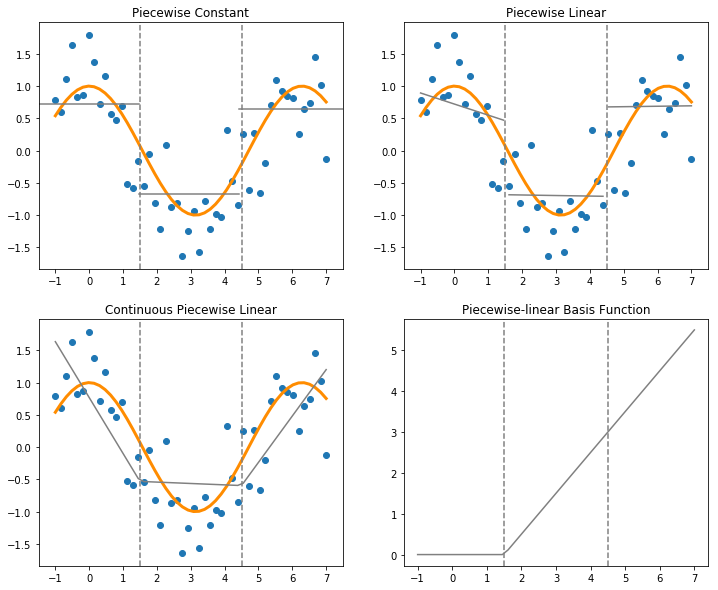

In [9]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
np.random.seed(42)

# Axes limits and knots
x_min, x_knot_1, x_knot_2, x_max = -1, 1.5, 4.5, 7

# Points generated from a cosine function with normal noise
x_true = scipy.linspace(x_min, x_max,50)
y_true = scipy.cos(x_true)
y_obs = y_true + np.random.normal(scale=0.5, size=len(x_true))

# Get x-y coordinates per region
x_region_1 = x_true[x_true <= x_knot_1]
x_region_2 = x_true[(x_knot_1 < x_true) & (x_true < x_knot_2)]
x_region_3 = x_true[x_true >= x_knot_2]
y_region_1 = y_true[x_true <= x_knot_1]
y_region_2 = y_true[(x_knot_1 < x_true) & (x_true < x_knot_2)]
y_region_3 = y_true[x_true >= x_knot_2]

# Piecewise constant fit ------------------------------------------------
# Plot cosine line and noisy data
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(x_true, y_true, linewidth=3, c='darkorange')
plt.scatter(x_true, y_obs)
# Plot knots
plt.axvline(x=x_knot_1, c='gray', ls='--')
plt.axvline(x=x_knot_2, c='gray', ls='--')
# Plot piecewise constant fits
plt.axhline(y=y_region_1.mean(), c='gray', xmin=0, xmax=0.33)
plt.axhline(y=y_region_2.mean(), c='gray', xmin=0.33, xmax=0.66)
plt.axhline(y=y_region_3.mean(), c='gray', xmin=0.66, xmax=1)
plt.title('Piecewise Constant')


# Piecewise linear fit --------------------------------------------------
# Calculate OLS coefficients from regression anatomy
beta_region_1 = ((y_region_1 - y_region_1.mean()).dot(x_region_1) / 
                (x_region_1**2).sum())
beta_region_2 = ((y_region_2 - y_region_2.mean()).dot(x_region_2) / 
                (x_region_2**2).sum())
beta_region_3 = ((y_region_3 - y_region_3.mean()).dot(x_region_3) / 
                (x_region_3**2).sum())

# Calculate regression fitted values
y_hat_region_1 = beta_region_1 * x_region_1 + y_region_1.mean()
y_hat_region_2 = beta_region_2 * x_region_2 + y_region_2.mean()
y_hat_region_3 = beta_region_3 * x_region_3 + y_region_3.mean()

# Plot cosine line and noisy data
plt.subplot(2, 2, 2)
plt.plot(x_true, y_true, linewidth=3, c='darkorange')
plt.scatter(x_true, y_obs)
# Plot knots
plt.axvline(x=x_knot_1, c='gray', ls='--')
plt.axvline(x=x_knot_2, c='gray', ls='--')
# Plot piecewise linear fits
plt.plot(x_region_1, y_hat_region_1, c='gray')
plt.plot(x_region_2, y_hat_region_2, c='gray')
plt.plot(x_region_3, y_hat_region_3, c='gray')
plt.title('Piecewise Linear')


# Continuous Piecewise Linear -------------------------------------------
h1 = scipy.ones_like(x_true)
h2 = scipy.copy(x_true)
h3 = scipy.where(x_true < x_knot_1, 0, x_true - x_knot_1)
h4 = scipy.where(x_true < x_knot_2, 0, x_true - x_knot_2)
H = scipy.vstack((h1, h2, h3, h4)).T
# Fit basis expansion via OLS
HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ y_obs)
y_hat = H @ beta

# Plot cosine line and noisy data
plt.subplot(2, 2, 3)
plt.plot(x_true, y_true, linewidth=3, c='darkorange')
plt.scatter(x_true, y_obs)
# Plot knots
plt.axvline(x=x_knot_1, c='gray', ls='--')
plt.axvline(x=x_knot_2, c='gray', ls='--')
# Plot piecewise linear fits
plt.plot(x_true, y_hat, c='gray')
plt.title('Continuous Piecewise Linear')


# Basis Function --------------------------------------------------------
plt.subplot(2, 2, 4)
# Plot knots
plt.axvline(x=x_knot_1, c='gray', ls='--')
plt.axvline(x=x_knot_2, c='gray', ls='--')
# Plot piecewise linear fits
plt.plot(x_true, h3, c='gray')
plt.title('Piecewise-linear Basis Function')

plt.show()

The upper left panel shows a piecewise constant function with three basis functions:

<p align="center">
<img src="img/piecewise_upper_left.png" width=200 style="display: block; margin: auto;" />
</p>

with the knots $\varepsilon_1$ and $\varepsilon_2$ equal to 1.5 and 4.5 respectively. Piecewise constant fit boils down to the mean of $Y$ in each region.

The upper right panel shows a piecewise linear fit. On top of the previous three basis functions, this one also requires three more, one for each region, that add the relation between $X$ and $Y$ in the usual linear regression way:

<p align="center">
<img src="img/piecewise_upper_right.png" width=250 height=250 style="display: block; margin: auto;" />
</p>

Note that as a result, in each region, $Y$ is modelled as its own mean in this region plus the effect of $X$ multiplied with its coefficient $\beta$. To see this, just substitute the six basis functions $h$ into the basis expansion formula at the beginning of this article!

One problem with the piecewise linear model is that it is discontinuous at the knots. This is not desired, as we would like the model to produce a unique output $y$ for every input $x$. This is not the case when $f(x)$ is discontinuous, as there is no unique output at the knot! Therefore, in most cases one would prefer to have a continuous model, such as the one in the lower left panel. It can be obtained by enforcing continuity at the knots through incorporating proper constraints into the basis functions:

<p align="center">
<img src="img/piecewise_lower_right.png" width=150 height=150 style="display: block; margin: auto;" />
</p>

where $t_+$ denotes the positive part. Basis function $h_3$ is shown in the lower right panel as an example.

#  Regression Splines

Piecewise polynomials, even those continuous at the knots, tend not be smooth: they rapidly change slope at the knots. To prevent this and increase their smoothness, it is enough to increase the order of the local polynomial and require the first two derivatives on both sides of the knot to be the same. A function that is continuous and has continuous first and second derivatives is called a **cubic spline** and can be represented with the following basis functions:

<p align="center">
<img src="img/cubic_spline_basis.png" width=150 height=175 style="display: block; margin: auto;" />
</p>

The code chunk below fits this cubic spline to the previously simulated data.

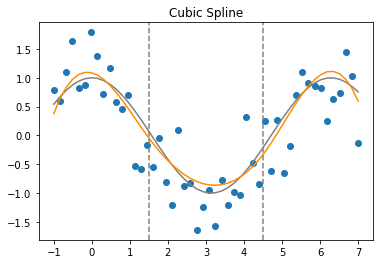

In [10]:
from scipy import linalg

# Construct H
h1 = scipy.ones_like(x_true)
h2 = scipy.copy(x_true)
h3 = h2 ** 2
h4 = h2 ** 3
h5 = scipy.where(x_true < x_knot_1, 0, (x_true - x_knot_1) ** 3)
h6 = scipy.where(x_true < x_knot_2, 0, (x_true - x_knot_2) ** 3)
H = scipy.vstack((h1, h2, h3, h4, h5, h6)).T

# Fit basis expansion via OLS
HH = H.T @ H
beta = linalg.solve(HH, H.T @ y_true)
y_hat = H @ beta

# Plot simulated data and cubic splie
plt.plot(x_true, y_obs, 'o')
plt.plot(x_true, y_true, color='gray')
plt.plot(x_true, y_hat, color='darkorange')
plt.title('Cubic Spline')

# Plot knots
plt.axvline(x=x_knot_1, c='gray', ls='--')
plt.axvline(x=x_knot_2, c='gray', ls='--')
             
plt.show()

The cubic spline above seems to fit well to the data. However, there is a danger associated with using this technique: the behaviour of cubic splines tends to be erratic near the boundaries, i.e. beyond the observed values of $X$. To smooth the function near the boundaries, one can use a special kind of spline known as a **natural spline**.

A natural cubic spline adds additional constraints, namely that the function is linear beyond the boundary knots. There will be a price paid in bias near the boundaries for this rather crude approximation, but assuming linearity near the boundaries, where we have less information anyway, is often considered reasonable.

A natural cubic spline with $K$ knots is represented by $K$ basis functions as follows:

<p align="center">
<img src="img/natural_spline.png" width=400 height=400 style="display: block; margin: auto;" />
</p>

where

<p align="center">
<img src="img/natural_spline_where.png" width=250 height=400 style="display: block; margin: auto;" />
</p>

Let's now employ cubic and natural splines to model the relation between wage and age, which could be reasonably expected to be non-linear - a perfect use case for splines. For this practical example, we will use the *statsmodels* package for fitting the splines and *patsy* for defining formulas. The data is adapted from "Introduction to Statistical Learning" by T. Hastie et al.

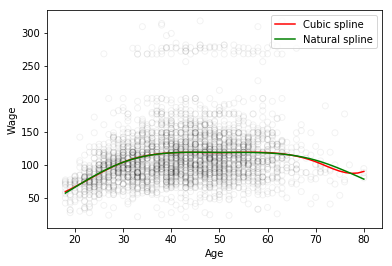

In [45]:
import pandas as pd
from patsy import dmatrix
import statsmodels.api as sm

# Load wage vs age data
df = pd.read_csv('wage_age_data.csv')

# Fit a cubic spline with knots at ages 30, 50 and 70
x_cubic = dmatrix('bs(x, knots=(30, 50, 70))', {'x': df['age']})
fit_cubic = sm.GLM(df['wage'], x_cubic).fit()

# Fit a natural spline with knots at ages 30, 50 and 70
x_natural = dmatrix('cr(x, knots=(30, 50, 70))', {'x': df['age']})
fit_natural = sm.GLM(df['wage'], x_natural).fit()

# Create spline lines for 50 evenly spaced values of age
xp = np.linspace(df['age'].min(), df['age'].max(), 50)
line_cubic = fit_cubic.predict(dmatrix('bs(xp, knots=(30, 50, 70))', {'xp': xp}))
line_natural = fit_natural.predict(dmatrix('cr(xp, knots=(30, 50, 70))', {'xp': xp}))

# Plot both spline lines and the data
plt.plot(xp, line_cubic, color='r', label='Cubic spline')
plt.plot(xp, line_natural, color='g', label='Natural spline')
plt.legend()
plt.scatter(df['age'], df['wage'], facecolor='None', edgecolor='k', alpha=0.05)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.show()

Both splines look similarly, but notice how the natural spline is linearly stable at the right edge of the plot as opposed to the cubic spline! Let's now look at one more way of obtaining splines.

# Smoothing Splines

All the methods discussed so far require us to select the number and locations of knots. **Smoothing splines** are a way to avoid the knot selection problem by using a maximal set of knots. In this approach the complexity of the fitted curve is not controlled by the knots, but rather by regularisation. 

One can think about smoothing splines as choosing such a function $f(X)$ from all possible functions with two continuous derivatives that minimizes the penalised residual sum of squares (RSS). In practice, $f(X)$ is almost always chosen to be a cubic function.

<p align="center">
<img src="img/smoothing_spline.png" width=400 height=400 style="display: block; margin: auto;" />
</p>

The first term in the RSS formula above measures the closeness to the data, while the second term penalizes curvature of the function. The trade-off between the two is controlled by the regularisation parameter $\lambda$:
* When $\lambda = 0$, $f(X)$ can by any arbitrarily complex function that interpolates the data, which would almost certainly lead to overfitting;
* When $\lambda = \infty$, the second term dominates and $f(X)$ is a simple linear fit, as no curvature at all is tolerated.

Setting the regularisation parameter somewhere in between these two extremes will hopefully produce a model that fits the data well, but does not overfit.

Let's fit smoothing spline to the wage-age data. We will use the *csaps* package for this, which defines the regularisation penalty slightly differently: it accepts values between 0 and 1, where 0 is a straight line and 1 is a natural cubic spline interpolation. The package also requires us to prepare the data before fitting the model. It can only handle one value of $Y$ for every $X$. Hence we will group by age and aggregate wage using the median.

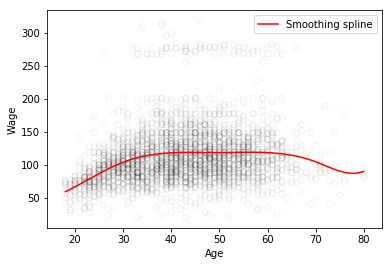

In [63]:
from csaps import UnivariateCubicSmoothingSpline

# Prepare data
df2 = df.sort_values("age").groupby("age")["wage"].median().reset_index()

# Fit smoothing spline with 0.85 regularisation
smoothing_spline = UnivariateCubicSmoothingSpline(df2['age'], df2['wage'], smooth=0.85)

# Create spline line for 50 evenly spaced values of age
xp = np.linspace(df2['age'].min(), df2['age'].max(), 50)
yp = smoothing_spline(xp)

# Plot the spline on top of all the data
plt.plot(xp, line_cubic, color='r', label='Smoothing spline')
plt.legend()
plt.scatter(df['age'], df['wage'], facecolor='None', edgecolor='k', alpha=0.05)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.show()

# Parameter Selection

The parameters defining regression splines encompass the degree of the spline and the number and placements of the knots. Sometimes domain knowledge about the relation being modelled can provide some indication as to where the knots should be placed. For smoothing splines, one has to choose the smoothing parameter. In practice, for all types of splines, the parameters can be tuned via cross-validation or set based on the analysis of the residual plot, depending on the goal of modelling. 

# Recap & Conclusion

1. **Polynomials and splines** allow to model non-linear relations, yielding more predictive and explanatory power than linear models. They achieve it by augmenting the input features with some transformations and then using the transformed features in linear models.
2. **Piecewise polynomials** are obtained by dividing the domain of input features into contiguous intervals and fitting a separate polynomial in each interval. They can be forced to be continuous at the knots, but they tend not to be smooth.
3. **Cubic splines** are an answer to piecewise polynomials' smoothness issue. They ensure smoothness at the knots by requiring the first two derivatives on both sides of the knot to be the same. However, they come with their own disadvantage: the behaviour of cubic splines tends to be erratic outside the observed values of inputs.
4. **Natural splines** add additional constraints, namely that the function is linear beyond the boundary knots, which makes it more reliable in those regions.
5. **Smoothing splines** are obtained by balancing the trade-off between closeness of the model to the data and the complexity of the fitted curve: regularisation parameter penalizes too complex functions that could lead to overfitting.
6. Parameters of regression (cubic and natural) spline encompass the number and placement of the knots. For smoothing splines, the regularisation parameter needs to be chosen. Parameter selection can be based on domain knowledge, cross-validation or residuals' properties.

All examples in this article featured univariate splines: there was only one input variable. In practice, one would typically want to include multiple predictors in the model. No worries: all the discussed methods naturally extend to a multivariate case. For instance, check out the MultivariateCubicSmoothingSpline class in the csaps package.

A final remark to the readers acquainted with the R language: R has more to offer than Python when it comes to spline modelling. Check out the bs() function from the splines package (which, by the way, is what Python's statsmodels mimics behind the hoods) and the mgcv package.

Thanks for reading! I hope you have learned something new. You can check out my other articles [here](https://michaloleszak.github.io/blog/).

# Sources

1. Hastie, T., Tibshirani, R., & Friedman, J. H. (2009). The elements of statistical learning: data mining, inference, and prediction. 2nd ed. New York: Springer.
2. https://pypi.org/project/csaps/